## InvestOps Tutorial - Portfolio Diversification

[Original repository on GitHub](https://github.com/Hvass-Labs/InvestOps-Tutorials)

Original author is [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

----

From [Monty Python's Life of Brian](https://www.youtube.com/watch?v=KHbzSif78qQ):
- Brian: "*You've got to think for yourselves! You're all individuals!*"
- Crowd in unison: "*Yes, we're all individuals!*"
- Brian: "*You're all different!*"
- Crowd in unison: "*Yes, we're all different!*"
- One man: "*I'm not!*"

## Introduction

This tutorial shows how to use the InvestOps functions `diversify_weights` and `diversify_weights_sparse` for improving the diversification of an investment portfolio, by lowering the correlations between different assets in the portfolio. The method is dubbed "Hvass Diversification" and is described in Section 8 of the [long paper](#refs) referenced below, and a more concise description is given in the [short paper](#refs). The method is simple, extremely fast to compute, and very robust to estimation errors in the correlation matrix.

Briefly explained, given some portfolio weights of how much we want to invest in each asset, the diversification method calculates the so-called "Full Exposure" of how much the portfolio is actually exposed to each asset, both through the direct investment in each asset, but also through the correlation with other assets in the portfolio. The diversification method then uses a fairly simple and extremely fast algorithm to find new portfolio weights, whose Full Exposure is equal to the originally desired portfolio weights.

Because the diversification method is only allowed to decrease the portfolio weights, the worst that can happen is that it moves too much of the portfolio into cash, which makes it extremely robust to estimation errors in the correlation matrix.

## References <a id="refs"></a>

- M.E.H. Pedersen, "*Simple Portfolio Optimization That Works!*", 2021. ([PDF](https://ssrn.com/abstract=3942552))

- M.E.H. Pedersen, "*Fast Portfolio Diversification*", 2022. ([PDF](https://ssrn.com/abstract=4009041))

## Google Colab

In [1]:
# If running in Google Colab, automatically install the required
# Python packages. This is NOT recommended on your local computer,
# unless you have setup a Python environment for this project.
# See the README on GitHub for detailed instructions.
if 'google.colab' in str(get_ipython()):
    !pip install investops numpy pandas matplotlib

## Imports

In [2]:
# Python packages.
import numpy as np
import numba as nb
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# InvestOps.
import investops as iv
from investops.diversify import (full_exposure, full_exposure_par,
                                 diversify_weights, log_to_dataframe)
from investops.random import rand_normal, rand_corr_normal, rand_zero
from investops.normalize import normalize_weights
from investops.check import fix_corr_matrix

In [4]:
# InvestOps for sparse correlation matrix.
from investops.diversify_sparse import (diversify_weights_sparse,
                    full_exposure_sparse, log_to_dataframe_sparse)
from investops.sparse import (sparse_corr_to_numpy,
                              sparse_to_matrix, matrix_to_sparse)

In [5]:
# InvestOps version.
iv.__version__

'0.3.0'

## Config

In [6]:
# Random number generator.
# The seed makes the experiments repeatable.
rng = np.random.default_rng(seed=80085)

## Positive Weights &amp; Correlations

The first example is very simple. We only have 3 assets in the portfolio and all the portfolio weights and correlations are positive.

In [7]:
# Originally desired portfolio weights.
weights_org = np.array([0.1, 0.2, 0.3])

# Correlation matrix.
corr = np.array([[1.0, 0.5, 0.7],
                 [0.5, 1.0, 0.2],
                 [0.7, 0.2, 1.0]])

In [8]:
# Calculate and show the Full Exposure of the original weights.
full_exposure(weights=weights_org, corr=corr)

array([0.17233688, 0.21771541, 0.32726136])

So the portfolio's Full Exposure is actually 17.2% for Asset 1, 21.8% for Asset 2, and 32.7% for Asset 3, even though the original portfolio weights were only 10%, 20%, and 30%. This is because the Full Exposure measures both the portfolio's direct investment in each asset, as well as the indirect exposure through correlations with other assets in the portfolio.

The goal is then to find new portfolio weights whose Full Exposure is equal to the originally desired portfolio weights, which is done by the function `diversify_weights`.

In [9]:
# Calculate and show the adjusted portfolio weights.
diversify_weights(weights_org=weights_org, corr=corr)

array([0.0435443 , 0.18911891, 0.28582913])

So we need to invest about 4.3% of the portfolio in Asset 1, 18.9% in Asset 2, and 28.6% in Asset 3, in order for their Full Exposures to equal the originally desired portfolio weights of 10%, 20%, and 30%.

## Using Asset Names

This example shows how to use the diversification function with Pandas Series and DataFrames instead of Numpy arrays, so we can use names for the assets in the portfolio. This example uses the same portfolio weights and correlation matrix from the previous example.

In [10]:
# Stock-tickers used as the asset names in the portfolio.
names = ['AAPL', 'GOOG', 'MSFT']

In [11]:
# Convert correlation matrix from Numpy to Pandas DataFrame.
df_corr = pd.DataFrame(data=corr, index=names, columns=names)
df_corr

,AAPL,GOOG,MSFT
AAPL,1.0,0.5,0.7
GOOG,0.5,1.0,0.2
MSFT,0.7,0.2,1.0


In [12]:
# Convert original weights from Numpy to Pandas DataFrame.
# It is recommended that you use a Pandas Series instead,
# but if you need to use a DataFrame, it is important that
# it is formatted like this, so it has a single column, the
# rows are the original weights for the different assets,
# and the index of the rows are the asset names.
df_weights_org = pd.DataFrame(data=weights_org, index=names)
df_weights_org

,0
AAPL,0.1
GOOG,0.2
MSFT,0.3


In [13]:
# Convert original weights from Numpy to Pandas Series.
ser_weights_org = pd.Series(data=weights_org, index=names)
ser_weights_org

AAPL    0.1
GOOG    0.2
MSFT    0.3
dtype: float64

In [14]:
# Call the diversifier with the weights being a Pandas Series.
diversify_weights(weights_org=ser_weights_org, corr=df_corr)

AAPL    0.043544
GOOG    0.189119
MSFT    0.285829
dtype: float64

In [15]:
# Call the diversifier with the weights being a Pandas DataFrame.
diversify_weights(weights_org=df_weights_org, corr=df_corr)

AAPL    0.043544
GOOG    0.189119
MSFT    0.285829
dtype: float64

Note that there is some extra overhead in using Pandas data with the `diversify_weights` function, because it checks the data is correct and also converts it to Numpy for internal processing, and then converts the result to a Pandas Series again.

So if you are using the diversification algorithm in a performance-critical application such as back-testing or High-Frequency Trading, then you may want to only pass Numpy arrays to the `diversify_weights` function for faster computation speed.

## Positive / Negative Weights &amp; Correlations

This example has both positive and negative portfolio weights and correlations. Some of the correlations are now deemed "good" and are therefore not included in the calculation of the Full Exposure, see Section 8.3 in the [paper](#refs) for an explanation of this.

In [16]:
# Originally desired portfolio weights.
weights_org = np.array([0.1, 0.2, -0.3])

# Correlation matrix.
corr = np.array([[1.0, -0.5, 0.7],
                 [-0.5, 1.0, -0.2],
                 [0.7, -0.2, 1.0]])

In [17]:
# Calculate and show the Full Exposure of the original weights.
full_exposure(weights=weights_org, corr=corr)

array([ 0.1       ,  0.2059126 , -0.30397368])

In [18]:
# Calculate and show the adjusted portfolio weights.
diversify_weights(weights_org=weights_org, corr=corr)

array([ 0.1       ,  0.1941687 , -0.29613922])

So we need to invest 10% of the portfolio in Asset 1 which is the same as the originally desired portfolio weight for Asset 1, because its correlations with the other two assets are deemed "good" so they don't require adjustment. But we should only invest 19.4% in Asset 2 and -29.6% in Asset 3. This makes all the Full Exposures equal to the originally desired portfolio weights of 10%, 20%, and -30%.

## "Crazy" Initial Weights

This example uses the same portfolio weights and correlations as in the previous example. But now we supply the diversification algorithm with a guess for the adjusted weights which is just "crazy" wrong. The diversification algorithm handles this very well, and already after the first iteration it has brought the portfolio weights back into a more normal range. See the sub-section titled "Crazy Initialization" in Section 8.12 of the [paper](#refs).

In [19]:
# Originally desired portfolio weights.
weights_org = np.array([0.1, 0.2, -0.3])

# A "crazy" wrong guess for the adjusted portfolio weights.
weights_guess = np.array([-123, 0.001, -789])

# Correlation matrix.
corr = np.array([[1.0, -0.5, 0.7],
                 [-0.5, 1.0, -0.2],
                 [0.7, -0.2, 1.0]])

In [20]:
# Calculate and show the Full Exposure of the guessed weights.
# These are very far from the originally desired portfolio weights.
full_exposure(weights=weights_guess, corr=corr)

array([-2.50363857e+02,  2.49621714e-01, -8.18580516e+02])

In [21]:
# Calculate the adjusted portfolio weights, using weights_guess
# as a starting guess for the adjusted weights. Log all iterations.
log = []
diversify_weights(weights_org=weights_org, corr=corr,
                  weights_guess=weights_guess, log=log)

array([ 0.1       ,  0.1941446 , -0.29615551])

In [22]:
# Show the log of all the iterations of weight adjustments.
log_to_dataframe(weights_org=weights_org, corr=corr, log=log)

,Weight 1,Full Exp. 1,Weight 2,Full Exp. 2,Weight 3,Full Exp. 3,MSE
Iteration,,,,,,,
0,-123.000000,-250.363857,0.001000,0.249622,-789.000000,-818.580516,2.441050e+05
1,0.049128,0.049128,0.000801,0.003148,-0.289159,-0.289175,1.381862e-02
2,0.100000,0.100000,0.050905,0.056588,-0.299983,-0.301000,6.856036e-03
3,0.100000,0.100000,0.179916,0.185800,-0.298987,-0.302564,6.940797e-05
4,0.100000,0.100000,0.193667,0.199508,-0.296453,-0.300302,1.111106e-07
5,0.100000,0.100000,0.194145,0.199980,-0.296156,-0.300013,1.918659e-10


The diversification algorithm corrected the "crazy" wrong guess for the portfolio weights already after the first iteration. The bottom-row of the log shows the same adjusted portfolio weights as in the previous example, which was initialized with the original portfolio weights.

Also note how the Mean Squared Error (MSE) between the Full Exposure and the originally desired weights decrease by several orders of magnitude in most iterations.

## Higher Precision

This example uses the same portfolio weights and correlations as in the previous example, but it uses the default weight-initialization instead of the "crazy" wrong guess. And now we want an even higher precision in the adjusted portfolio weights, so their Full Exposures are even closer to the originally desired weights. This is done by setting the argument `tol` (short for "error **tol**erance") to a value that is close to, but not equal to zero.

In [23]:
# Calculate the adjusted portfolio weights with higher precision.
# Log all iterations.
log = []
diversify_weights(weights_org=weights_org, corr=corr,
                  tol=1e-20, log=log)

array([ 0.1       ,  0.19416484, -0.29614184])

In [24]:
# Show the log of all the iterations of weight adjustments.
log_to_dataframe(weights_org=weights_org, corr=corr, log=log)

,Weight 1,Full Exp. 1,Weight 2,Full Exp. 2,Weight 3,Full Exp. 3,MSE
Iteration,,,,,,,
0,0.1,0.1,0.200000,0.205913,-0.300000,-0.303974,1.691634e-05
1,0.1,0.1,0.194257,0.200091,-0.296078,-0.299938,4.039732e-09
2,0.1,0.1,0.194169,0.200004,-0.296139,-0.299997,6.963000e-12
3,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,1.200798e-14
4,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,2.070865e-17
5,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,3.571366e-20
6,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,6.159123e-23
7,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,1.061951e-25
8,0.1,0.1,0.194165,0.200000,-0.296142,-0.300000,1.841171e-28


Compared to the previous section that used the default argument `tol=1e-3` and which needed 5 iterations of the diversification algorithm to converge, we now need 11 iterations of the algorithm when `tol=1e-20`.

Note that the Mean Squared Error (MSE) decreases by several orders of magnitude in each iteration and eventually becomes zero, which means the Full Exposures have become exactly equal to the originally desired portfolio weights.

## Time Usage

Let us now measure how long it takes to use the diversification algorithm on a portfolio with 1000 assets. We will generate random portfolio weights and correlations.

In [25]:
# Number of assets in the portfolio.
num_assets = 1000

# Originally desired portfolio weights.
# These are randomly generated from a normal distribution.
weights_org = rand_normal(rng=rng, size=num_assets,
                          mean=0.0, std=0.05, low=-0.2, high=0.2)

# Correlation matrix randomly generated from a normal distribution.
corr = rand_corr_normal(rng=rng, num_assets=num_assets, mean=0.2)

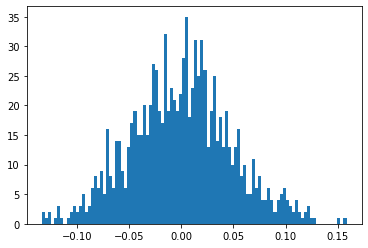

In [26]:
# Histogram of the randomly generated portfolio weights.
plt.hist(weights_org, bins=100);

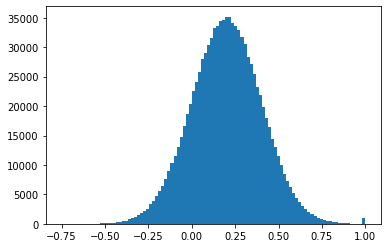

In [27]:
# Histogram of the randomly generated correlation coefficients.
plt.hist(corr.flatten(), bins=100);

In [28]:
%%timeit
# Measure the time-usage of the diversification algorithm.
diversify_weights(weights_org=weights_org, corr=corr)

17.6 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So the diversification algorithm only needed about **20 milli-seconds** to converge to a near-optimal solution for a portfolio with 1000 assets. This was run on a computer with a 2.6 GHz CPU (3.5 GHz boost). The time-usage obviously depends on the number of assets in the portfolio, the weights and correlations, and the speed of the computer.

The time-complexity is quadratic if you hold the error tolerance fixed (which is the `tol` argument in the `diversify_weights` function). This means that for a portfolio of 10,000 assets, you should expect a time-usage of 10\*10\*20 milli-seconds = 2 seconds.

## Compare Weights Before &amp; After

Let us now compare the portfolio weights before and after they were adjusted by the diversification algorithm. This uses the same portfolio weights and correlations that were randomly generated in the previous example.

In [29]:
# Calculate the adjusted portfolio weights.
weights_new = diversify_weights(weights_org=weights_org, corr=corr)

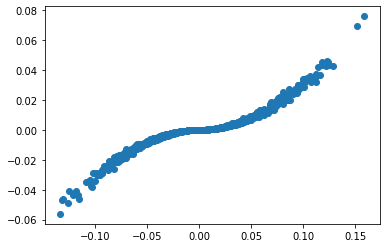

In [30]:
# Scatter-plot of the original portfolio weights on the x-axis
# and the adjusted portfolio weights on the y-axis.
plt.scatter(weights_org, weights_new);

It appears that the diversification algorithm "compresses" the portfolio weights in a smooth but also non-linear way, so the weights that were originally closer to zero get moved dis-proportionally closer to zero. This of course depends on the exact values of the portfolio weights and correlations. It would be an interesting topic for you to research further. Perhaps it could lead to deeper insights into why the diversification algorithm works so well.

## Weight Normalization

The portfolio weights that are output from the function `diversify_weights` are not normalized, so they can sum to more than 1. This example shows how to normalize the portfolio weights using the function `normalize_weights` which can handle both positive and negative weights. We are reusing the weights and correlations from the previous examples.

In [31]:
# Normalize the portfolio weights so the positive weights
# sum to max 1.0, the negative weights sum to min -0.5,
# and the ratio between the sums of positive and negative
# weights is at most 0.2.
weights_norm, cash = \
    normalize_weights(weights=weights_new, limit_pos=1.0,
                      limit_neg=-0.5, max_ratio=0.2)

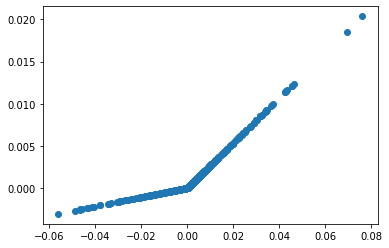

In [32]:
# Show the weights before (x-axis) and after (y-axis) normalization.
plt.scatter(weights_new, weights_norm);

Note that the function `normalize_weights` also accepts input-weights as 2-dimensional Numpy Arrays or Pandas DataFrames, where the rows are for time-steps and the columns are for the different assets. So you can use the function to normalize the weights for many time-steps at once, e.g. for use in back-testing an investing strategy.

## Sparse Correlation Matrix

We will now use a so-called sparse correlation matrix whose elements are mostly zero. We can ignore correlations that are zero because they will not have any effect on the calculation of the Full Exposure. This can speed up the diversification algorithm.

### Sparse Correlation - Small Example

We begin with an example of a small portfolio with only 3 stocks.

In [33]:
# Number of assets in the portfolio.
num_assets = 3

In [34]:
# Originally desired portfolio weights.
weights_org = pd.Series(dict(MSFT=0.1, BBBY=0.3, AAPL=0.2))
weights_org

MSFT    0.1
BBBY    0.3
AAPL    0.2
dtype: float64

In [35]:
# Sparse correlation matrix.
# Here the correlation between stocks MSFT and BBBY is 0.5
# and the correlation between stocks AAPL and BBBY is 0.1
corr_sparse = [('MSFT', 'BBBY', 0.5), ('AAPL', 'BBBY', 0.1)]

# WARNING! The diagonal and symmetrical correlations are omitted,
# because the diversification algorithm handles this automatically.
# If you include the diagonal and lower-triangle matrix then the
# diversification algorithm gives the wrong result! So you should
# only use the upper triangle of the correlation matrix!

In [36]:
# The above format for a sparse correlation matrix is easy to
# write and understand, but cannot be used directly by the Python
# functions for diversifying the portfolio, because they use the
# Numba Jit compiler to speed up the runtime, and that currently
# does not support the above format properly so it runs slowly.
# So we need to convert the sparse matrix to another format.

# Convert the sparse correlation matrix into 3 tuples.
corr_i, corr_j, corr_coef = zip(*corr_sparse)

# Print the 3 tuples that define the sparse correlation matrix.
print(f'corr_i: {corr_i}')
print(f'corr_j: {corr_j}')
print(f'corr_coef: {corr_coef}')

corr_i: ('MSFT', 'AAPL')
corr_j: ('BBBY', 'BBBY')
corr_coef: (0.5, 0.1)


In [37]:
# Convert the weights and sparse correlation matrix into Numpy
# arrays which use integers instead of stock-tickers to identify
# the assets in the portfolio.
weights_org_np, corr_i_np, corr_j_np, corr_coef_np = \
    sparse_corr_to_numpy(weights=weights_org, corr_i=corr_i,
                         corr_j=corr_j, corr_coef=corr_coef)

# Print the weights and Numpy arrays that define the sparse
# correlation matrix. This is in so-called Coordinate (COO) format.
print(f'weights_org_np: {weights_org_np}')
print(f'corr_i_np: {corr_i_np}')
print(f'corr_j_np: {corr_j_np}')
print(f'corr_coef_np: {corr_coef_np}')

weights_org_np: [0.1 0.3 0.2]
corr_i_np: [0 2]
corr_j_np: [1 1]
corr_coef_np: [0.5 0.1]


In [38]:
# Create the dense correlation matrix, so we can compare the sparse
# and dense versions of the diversification algorithm later.
corr_dense = sparse_to_matrix(sparse_i=corr_i_np, sparse_j=corr_j_np, sparse_v=corr_coef_np,
                              shape=(num_assets, num_assets))

# Make the correlation matrix symmetrical.
corr_dense += corr_dense.T

# Fill the diagonal with 1.
np.fill_diagonal(corr_dense, 1.0)

# Show the dense correlation matrix.
corr_dense

array([[1. , 0.5, 0. ],
       [0.5, 1. , 0.1],
       [0. , 0.1, 1. ]])

In [39]:
# Calculate the Full Exposure using the SPARSE correlation matrix.
# NOTE: This only works with Numpy arrays! You cannot use Pandas
# data, and you should not use Python lists because it is slow!
full_exposure_sparse(weights=weights_org_np, corr_i=corr_i_np,
                     corr_j=corr_j_np, corr_coef=corr_coef_np)

array([0.13228757, 0.3132092 , 0.20149442])

In [40]:
# Calculate the Full Exposure using the DENSE correlation matrix.
full_exposure(weights=weights_org_np, corr=corr_dense)

array([0.13228757, 0.3132092 , 0.20149442])

In [41]:
# Diversify the portfolio weights using the SPARSE correlation matrix.
# This uses Numpy arrays as input.
diversify_weights_sparse(weights_org=weights_org_np,
                         corr_i=corr_i_np, corr_j=corr_j_np,
                         corr_coef=corr_coef_np)

array([0.07020497, 0.29034873, 0.19855427])

In [42]:
# Diversify the portfolio weights using the DENSE correlation matrix.
# This uses Numpy arrays as input.
diversify_weights(weights_org=weights_org_np, corr=corr_dense)

array([0.07020497, 0.29034873, 0.19855427])

In [43]:
# Diversify the portfolio weights using the SPARSE correlation matrix.
# This uses Pandas Series for the weights and lists of strings for
# corr_i and j, which are automatically converted to Numpy arrays.
# The iterations of the algorithm are also recorded in the log.
log_sparse = []
diversify_weights_sparse(weights_org=weights_org, corr_i=corr_i,
                         corr_j=corr_j, corr_coef=corr_coef,
                         log=log_sparse)

MSFT    0.070205
BBBY    0.290349
AAPL    0.198554
dtype: float64

In [44]:
# Diversify the portfolio weights using the DENSE correlation matrix.
# This uses Pandas Series for the weights and DataFrame for the
# corr. matrix, which are automatically converted to Numpy arrays.
# The iterations of the algorithm are also recorded in the log.
log_dense = []
diversify_weights(weights_org=weights_org, corr=corr_dense, log=log_dense)

MSFT    0.070205
BBBY    0.290349
AAPL    0.198554
dtype: float64

In [45]:
# Show the log for the algorithm using the SPARSE corr. matrix.
df_log_sparse = log_to_dataframe_sparse(log=log_sparse,
                    weights_org=weights_org_np, corr_i=corr_i_np,
                    corr_j=corr_j_np, corr_coef=corr_coef_np)
df_log_sparse

,Weight 1,Full Exp. 1,Weight 2,Full Exp. 2,Weight 3,Full Exp. 3,MSE
Iteration,,,,,,,
0,0.100000,0.132288,0.300000,0.313209,0.200000,0.201494,4.064010e-04
1,0.075593,0.105568,0.287348,0.297606,0.198517,0.199948,1.224562e-05
2,0.071606,0.101551,0.289659,0.299437,0.198568,0.200011,9.078328e-07
3,0.070512,0.100437,0.290203,0.299850,0.198557,0.200003,7.121535e-08
4,0.070205,0.100124,0.290349,0.299958,0.198554,0.200001,5.670957e-09


In [46]:
# Show the log for the algorithm using the DENSE corr. matrix.
df_log_dense = log_to_dataframe(log=log_dense, weights_org=weights_org_np,
                                corr=corr_dense)
df_log_dense

,Weight 1,Full Exp. 1,Weight 2,Full Exp. 2,Weight 3,Full Exp. 3,MSE
Iteration,,,,,,,
0,0.100000,0.132288,0.300000,0.313209,0.200000,0.201494,4.064010e-04
1,0.075593,0.105568,0.287348,0.297606,0.198517,0.199948,1.224562e-05
2,0.071606,0.101551,0.289659,0.299437,0.198568,0.200011,9.078328e-07
3,0.070512,0.100437,0.290203,0.299850,0.198557,0.200003,7.121535e-08
4,0.070205,0.100124,0.290349,0.299958,0.198554,0.200001,5.670957e-09


In [47]:
# Show the log's min/max difference between SPARSE and DENSE results.
# These are all zero, which means the results of the SPARSE and DENSE
# algorithms are exactly the same.
df_log_dif = df_log_sparse - df_log_dense
df_log_dif.T.describe().T[['min', 'max']]

,min,max
Iteration,,
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


### Sparse Correlation - Big Example

Let us now consider a larger example with 1000 assets, where only about 1% of the correlation coefficients are non-zero.

In [48]:
# Number of assets in the portfolio.
num_assets = 1000

# Generate random portfolio weights.
weights_org = rand_normal(rng=rng, size=num_assets,
                          low=-1.0, high=1.0)

# Generate random correlation matrix.
corr_dense = rand_corr_normal(rng=rng, num_assets=num_assets)

# Randomly set about 99% of the corr. matrix to zero.
corr_dense = rand_zero(rng=rng, x=corr_dense, prob=0.99)

# Make the correlation matrix symmetrical again.
corr_dense += corr_dense.T

# Ensure it is a valid correlation matrix.
# This also clips the correlation coefficients between -1 and 1.
fix_corr_matrix(corr=corr_dense, copy=False)

# Only use the upper-triangle of the correlation matrix,
# otherwise the sparse algorithm would use the correlations twice.
corr_dense_triu = np.triu(corr_dense, k=1)

# Convert to a sparse matrix in Coordinate (COO) format.
corr_i, corr_j, corr_coef = matrix_to_sparse(mat=corr_dense_triu)

In [49]:
# Convert the sparse matrix to a dense matrix.
mat = sparse_to_matrix(shape=(num_assets, num_assets),
           sparse_i=corr_i, sparse_j=corr_j, sparse_v=corr_coef)

# Raise an exception if there are big differences.
np.testing.assert_allclose(mat, corr_dense_triu)

In [50]:
# Diversify the portfolio weights using the SPARSE correlation matrix.
# This uses Pandas Series for the weights and lists of strings for
# corr_i and j, which are automatically converted to Numpy arrays.
log_sparse = []
weights_new_sparse = diversify_weights_sparse(weights_org=weights_org,
                                corr_i=corr_i, corr_j=corr_j,
                                corr_coef=corr_coef, log=log_sparse)

In [51]:
# Diversify the portfolio weights using the DENSE correlation matrix.
# This uses Pandas Series for the weights and DataFrame for the corr.
# matrix, which are automatically converted to Numpy arrays.
log_dense = []
weights_new_dense = diversify_weights(weights_org=weights_org,
                                corr=corr_dense, log=log_dense)

In [52]:
# Test the diversified weights are nearly identical
# when calculated by the SPARSE and DENSE algorithms.
# This raises an exception if there are big differences.
np.testing.assert_allclose(weights_new_sparse, weights_new_dense)

### Sparse vs. Dense Algorithms Results

In [53]:
# Show the log for the SPARSE algorithm.
df_log_sparse = log_to_dataframe_sparse(weights_org=weights_org,
                    corr_i=corr_i, corr_j=corr_j, corr_coef=corr_coef, log=log_sparse)
df_log_sparse.head()

,Weight 1,Full Exp. 1,Weight 2,Full Exp. 2,Weight 3,Full Exp. 3,Weight 4,Full Exp. 4,Weight 5,Full Exp. 5,...,Full Exp. 996,Weight 997,Full Exp. 997,Weight 998,Full Exp. 998,Weight 999,Full Exp. 999,Weight 1000,Full Exp. 1000,MSE
Iteration,,,,,,,,,,,,,,,,,,,,,
0,-0.045931,-0.052103,-0.040210,-0.045229,-0.046094,-0.046625,0.038366,0.044617,0.073708,0.082357,...,-0.018791,-0.025225,-0.033810,4.264695e-05,0.000618,-0.003279,-0.006187,-0.012436,-0.015360,3.613347e-05
1,-0.040491,-0.045555,-0.035748,-0.039917,-0.045569,-0.045964,0.032992,0.038425,0.065968,0.073318,...,-0.013370,-0.018820,-0.026022,2.941466e-06,0.000150,-0.001738,-0.004039,-0.010068,-0.012520,6.825531e-07
2,-0.040826,-0.045796,-0.036009,-0.040125,-0.045698,-0.046080,0.032941,0.038370,0.066319,0.073679,...,-0.012549,-0.018243,-0.025410,8.369937e-07,0.000080,-0.001411,-0.003588,-0.010000,-0.012451,8.977922e-08
3,-0.040947,-0.045883,-0.036086,-0.040185,-0.045712,-0.046091,0.032938,0.038367,0.066345,0.073715,...,-0.012291,-0.018110,-0.025271,4.484521e-07,0.000058,-0.001290,-0.003410,-0.009988,-0.012440,1.516588e-08
4,-0.040990,-0.045913,-0.036108,-0.040202,-0.045715,-0.046094,0.032938,0.038367,0.066339,0.073714,...,-0.012204,-0.018077,-0.025237,3.287387e-07,0.000050,-0.001240,-0.003336,-0.009984,-0.012437,2.871265e-09


In [54]:
# Show the log for the DENSE algorithm.
df_log_dense = log_to_dataframe(weights_org=weights_org,
                                corr=corr_dense, log=log_dense)
df_log_dense.head()

,Weight 1,Full Exp. 1,Weight 2,Full Exp. 2,Weight 3,Full Exp. 3,Weight 4,Full Exp. 4,Weight 5,Full Exp. 5,...,Full Exp. 996,Weight 997,Full Exp. 997,Weight 998,Full Exp. 998,Weight 999,Full Exp. 999,Weight 1000,Full Exp. 1000,MSE
Iteration,,,,,,,,,,,,,,,,,,,,,
0,-0.045931,-0.052103,-0.040210,-0.045229,-0.046094,-0.046625,0.038366,0.044617,0.073708,0.082357,...,-0.018791,-0.025225,-0.033810,4.264695e-05,0.000618,-0.003279,-0.006187,-0.012436,-0.015360,3.613347e-05
1,-0.040491,-0.045555,-0.035748,-0.039917,-0.045569,-0.045964,0.032992,0.038425,0.065968,0.073318,...,-0.013370,-0.018820,-0.026022,2.941466e-06,0.000150,-0.001738,-0.004039,-0.010068,-0.012520,6.825531e-07
2,-0.040826,-0.045796,-0.036009,-0.040125,-0.045698,-0.046080,0.032941,0.038370,0.066319,0.073679,...,-0.012549,-0.018243,-0.025410,8.369937e-07,0.000080,-0.001411,-0.003588,-0.010000,-0.012451,8.977922e-08
3,-0.040947,-0.045883,-0.036086,-0.040185,-0.045712,-0.046091,0.032938,0.038367,0.066345,0.073715,...,-0.012291,-0.018110,-0.025271,4.484521e-07,0.000058,-0.001290,-0.003410,-0.009988,-0.012440,1.516588e-08
4,-0.040990,-0.045913,-0.036108,-0.040202,-0.045715,-0.046094,0.032938,0.038367,0.066339,0.073714,...,-0.012204,-0.018077,-0.025237,3.287387e-07,0.000050,-0.001240,-0.003336,-0.009984,-0.012437,2.871265e-09


In [55]:
# Show the log's min/max difference between SPARSE and DENSE results.
df_log_dif = df_log_sparse - df_log_dense
df_log_dif.T.describe().T[['min', 'max']]

,min,max
Iteration,,
0,-1.387779e-17,1.387779e-17
1,-2.775558e-17,2.775558e-17
2,-8.326673e-17,2.775558e-17
3,-2.775558e-17,2.775558e-17
4,-2.775558e-17,2.775558e-17


Note how the results are slightly different between the sparse and dense diversification algorithms. Mathematically speaking they are calculating the exact same thing, but because the computations are ordered differently in the two algorithms, the floating-point computations are rounded slightly differently, thus giving small differences in the results.

### Sparse vs. Dense Algorithms Time-Usage

The following shows that the SPARSE algorithms are roughly 25-30 times faster than the DENSE algorithms, even though the SPARSE correlation matrix only has about 1% of the correlation coefficients of the DENSE matrix, so we might expect the SPARSE algorithms to be 100 times faster than the DENSE algorithms. The difference is probably due to various kinds of computational overhead, so the time-usage of the SPARSE algorithm does not scale perfectly with the sparsity of the correlation matrix.

The [short paper](#refs) referenced above has more detailed comparisons of the time-usage.

In [56]:
# Compare time-usage of the SPARSE and DENSE diversification algorithms.
%timeit diversify_weights_sparse(weights_org=weights_org, corr_i=corr_i, corr_j=corr_j, corr_coef=corr_coef)
%timeit diversify_weights(weights_org=weights_org, corr=corr_dense)

422 µs ± 5.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
11.1 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
# Compare time-usage of the SPARSE and DENSE Full Exposure algorithms.
%timeit full_exposure_sparse(weights=weights_org, corr_i=corr_i, corr_j=corr_j, corr_coef=corr_coef)
%timeit full_exposure(weights=weights_org, corr=corr_dense)

81.2 µs ± 934 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.96 ms ± 17 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Parallel vs. Serial Execution

The function `full_exposure_par` is the parallel version of the function `full_exposure`, and the function `diversify_weights` can be run in parallel mode by passing the argument `parallel=True`.

For portfolios with less than 200 assets, the serial version is probably faster than the parallel version. You should conduct timing experiments like the following for your particular use-case and computer, to see whether the parallel or serial version is faster for you.

Note that the functions for using sparse correlation matrices currently do not support parallel execution.

In [58]:
# Run the parallel versions once so their Numba JIT compilations
# do not interfere with the timing measurements below.
full_exposure_par(weights=weights_org, corr=corr_dense);
diversify_weights(weights_org=weights_org, corr=corr_dense, parallel=True);

In [59]:
# Compare time-usage of the SERIAL and PARALLEL diversification algorithms.
# Serial version.
%timeit diversify_weights(weights_org=weights_org, corr=corr_dense)
# Parallel version.
# Note the time-usage may not scale perfectly with the number of
# CPU cores, because only a part of the algorithm is run in parallel.
%timeit diversify_weights(weights_org=weights_org, corr=corr_dense, parallel=True)

11.2 ms ± 4.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.37 ms ± 4.89 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
# Compare time-usage of the SERIAL and PARALLEL Full Exposure algorithms.
# Serial version.
%timeit full_exposure(weights=weights_org, corr=corr_dense)
# Parallel version.
%timeit full_exposure_par(weights=weights_org, corr=corr_dense)

2 ms ± 58 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
322 µs ± 660 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [61]:
# You can change the number of execution threads as follows.

# Save the original number of execution threads that are available.
nb_threads = nb.config.NUMBA_NUM_THREADS

# Set the number of execution threads to 1, which effectively
# makes the code run in serial mode. On Linux there is no
# performance penalty versus using parallel mode, see the following:
# https://numba.discourse.group/t/switching-between-parallel-serial-mode/1125/3
nb.set_num_threads(1)

# Set the number of execution threads to 2.
nb.set_num_threads(2)

# Restore the original number of execution threads available.
nb.set_num_threads(nb_threads)    

## License (MIT)

This is published under the [MIT License](https://github.com/Hvass-Labs/InvestOps-Tutorials/blob/main/LICENSE) which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/Hvass-Labs/InvestOps-Tutorials).